Song et al. (2017, 2018) use a test function based on audiometry data. They don't include code for generating it, so we replicate it here. The description in the paper is: 

> To simulate the 2D psychometric field, an audiogram shape for each simulated participant was first defined. For each audiogram shape, approximation of 1 of 4 human audiometric phenotypes (Dubno et al., 2013) by spline interpolation and linear extrapolation formed a continuous threshold curve across frequency space.

Dennis Barbour (corresponding author) further confirmed: 
> We did pull the octave thresholds from the figure in Dubno, et al. We then used cubic splines to interpolate the thresholds between those values with semitone resolution. We also extended the thresholds up and down one octave with linear extrapolation (I believe extending from the slope of the splines at the upper and lower bounds). 

So we do this here. First, I traced Figure 2 from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3767874/ using https://apps.automeris.io/wpd/ to get the raw data, which is included here: 

In [2]:
import io
import pandas as pd
raw = '''\
freq,thresh,phenotype
0.25,6.816404934,Older-normal
0.5,5.488517768,Older-normal
1,3.512856308,Older-normal
2,5.909671334,Older-normal
3,6.700337017,Older-normal
4,10.08761498,Older-normal
6,13.46962853,Older-normal
8,12.97026073,Older-normal
0.25,5.520856346,Sensory
0.5,4.19296918,Sensory
1,5.618122764,Sensory
2,19.83681866,Sensory
3,42.00403606,Sensory
4,53.32679981,Sensory
6,62.0527006,Sensory
8,66.08775286,Sensory
0.25,21.2291323,Metabolic
0.5,22.00676227,Metabolic
1,24.24163372,Metabolic
2,33.92590956,Metabolic
3,41.35626176,Metabolic
4,47.17294402,Metabolic
6,54.1174655,Metabolic
8,58.31446133,Metabolic
0.25,20.25772154,Metabolic+Sensory
0.5,20.71121368,Metabolic+Sensory
1,21.97442369,Metabolic+Sensory
2,37.48866818,Metabolic+Sensory
3,53.17814263,Metabolic+Sensory
4,64.01507567,Metabolic+Sensory
6,75.00818649,Metabolic+Sensory
8,76.61433583,Metabolic+Sensory'''
dubno_data = pd.read_csv(io.StringIO(raw))

dfont: score(<Font '.SF NS Display Condensed' (SFNSDisplayCondensed-Medium.otf) normal normal 600 condensed>) = 10.44
2021-02-10 13:27:55,082 [DEBUG  ] findfont: score(<Font 'Inconsolata for Powerline' (Inconsolata Bold for Powerline.ttf) normal normal 700 normal>) = 10.335
2021-02-10 13:27:55,083 [DEBUG  ] findfont: score(<Font 'Times' (Times.ttc) normal normal 400 normal>) = 10.05
2021-02-10 13:27:55,083 [DEBUG  ] findfont: score(<Font 'Noto Sans Brahmi' (NotoSansBrahmi-Regular.ttf) normal normal 400 normal>) = 10.05
2021-02-10 13:27:55,084 [DEBUG  ] findfont: score(<Font 'Roboto Mono for Powerline' (Roboto Mono Bold Italic for Powerline.ttf) italic normal 700 normal>) = 11.335
2021-02-10 13:27:55,084 [DEBUG  ] findfont: score(<Font 'Roboto Condensed' (RobotoCondensed-Italic.ttf) italic normal 400 condensed>) = 11.25
2021-02-10 13:27:55,085 [DEBUG  ] findfont: score(<Font 'SF UI Display' (SFUIDisplay-Semibold.ttf) normal normal 600 normal>) = 10.24
2021-02-10 13:27:55,085 [DEBUG  ] f

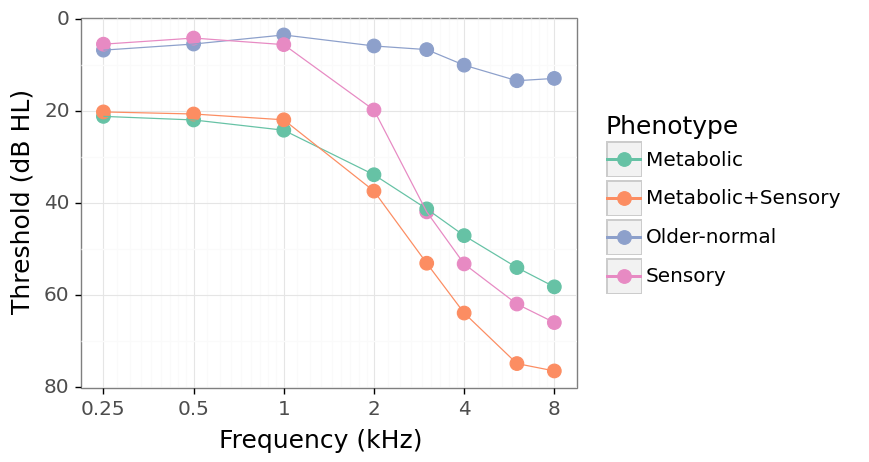

<ggplot: (8777664386166)>

In [3]:
import seaborn as sns
# sns.set_theme()

from plotnine import *
ggplot(dubno_data, aes(x="freq", y="thresh", colour="phenotype")) +\
geom_point(size=5) + geom_line() +\
scale_x_log10(breaks=[0.25, 0.5, 1, 2, 4, 8]) +\
scale_y_reverse() + theme_bw(base_size=18) +\
scale_colour_brewer(type="qualitative", palette="Set2") +\
labs(x="Frequency (kHz)", y="Threshold (dB HL)", colour="Phenotype")


In [4]:
# now for each phenotype we add the desired places to interpolate to, 
import numpy as np
import matplotlib.pyplot as plt
octave_min = np.round(np.log2(dubno_data.freq.min()))
octave_max = np.round(np.log2(dubno_data.freq.max())) 
num_octaves = int(octave_max - octave_min) + 2
num_phenotypes = len(dubno_data.phenotype.unique())
desired_x = np.tile(np.logspace(octave_min-1, octave_max+1, 12*num_octaves, base=2), num_phenotypes)
desired_phenotype = np.repeat(dubno_data.phenotype.unique(), 12*num_octaves)
desired_interp = pd.DataFrame({"freq":desired_x, "phenotype":desired_phenotype})
desired_d = dubno_data.append(desired_interp)
from scipy.interpolate import CubicSpline
from scipy.interpolate import interp1d

def make_song_threshfun(x, y): 
    """
    makes a function that generates a threshold function as in Song
    et al. 
    """
    f_interp = CubicSpline(x, y, extrapolate=False)
    f_extrap = interp1d(x, y, fill_value="extrapolate")
    def f_combo(x): 
        # interpolate first
        interpolated = f_interp(x)
        # whatever is nan needs extrapolating
        interpolated[np.isnan(interpolated)] = f_extrap(x[np.isnan(interpolated)])
        return interpolated
    return f_combo

def interp_fun(d):
    d = d.drop(columns="phenotype")
    interp_from = d[~np.isnan(d.thresh)]
    interp_to = d[np.isnan(d.thresh)]
    
    song_threshfun = make_song_threshfun(interp_from.freq, interp_from.thresh)
    interp_to.thresh = song_threshfun(interp_to.freq)
    
    d = pd.concat([interp_from, interp_to])
    return d

desired_d = desired_d.groupby("phenotype").apply(interp_fun).reset_index().drop(columns="level_1")

# same plot, now we have points from Dubno but lines by cubic interpolation
p2 = ggplot(desired_d, aes(x="freq", y="thresh", colour="phenotype")) +\
geom_line() +geom_point(data=dubno_data, size=5)+\
scale_x_log10(breaks=[0.25, 0.5, 1, 2, 4, 8]) +\
scale_y_reverse() + theme_bw(base_size=18) +\
scale_colour_brewer(type="qualitative", palette="Set2") +\
labs(x="Frequency (kHz)", y="Threshold (dB HL)", colour="Phenotype")
p2.save('Dubno_testfuns.pdf')

2021-02-10 13:27:56,625 [DEBUG  ] Assigning font /b'F1' = '/Users/mshvarts/anaconda3/envs/ae/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
2021-02-10 13:27:56,700 [DEBUG  ] Embedding font /Users/mshvarts/anaconda3/envs/ae/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
2021-02-10 13:27:56,701 [DEBUG  ] Writing TrueType font.


In [5]:
from scipy.stats import norm

def make_songetal_testfun(x, y, beta=2):
    """
    Makes a test function, Song et al. style
    """
    # first, make the threshold fun
    threshfun = make_song_threshfun(x, y)
    
    # now make it into a test function
    def test_function(x, cdf=False): 
        logfreq = x[...,0]
        intensity = x[...,1]
        thresh = threshfun(2**logfreq)
        return norm.cdf((intensity-thresh)/beta) if cdf else (intensity-thresh)/beta

    return test_function
    


2021-02-10 13:29:59,130 [DEBUG  ] locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fbb89fc5be0>
2021-02-10 13:29:59,131 [DEBUG  ] Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fbb89fc5be0> on colorbar
2021-02-10 13:29:59,132 [DEBUG  ] Setting pcolormesh
2021-02-10 13:29:59,156 [DEBUG  ] Assigning font /b'F1' = '/Users/mshvarts/anaconda3/envs/ae/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
2021-02-10 13:29:59,306 [DEBUG  ] Embedding font /Users/mshvarts/anaconda3/envs/ae/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
2021-02-10 13:29:59,307 [DEBUG  ] Writing TrueType font.


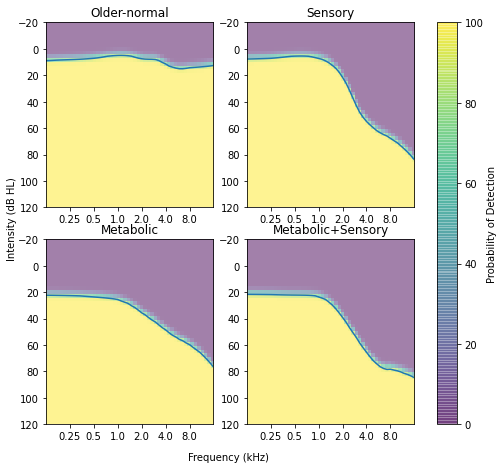

In [13]:
from bayesopt_server.utils import _dim_grid, get_lse_contour
lb = [np.log2(0.125), -20]
ub = [np.log2(16), 120]
gridsize=50
grid = _dim_grid(lower=lb, upper=ub, dim=2, gridsize=gridsize)
figmap = {'Older-normal':(0,0), 'Sensory':(0,1), 'Metabolic':(1,0), 'Metabolic+Sensory':(1,1)}
fig, axs = plt.subplots(2, 2, figsize=(7.5, 6.5))
fig.tight_layout(rect=[0.05, 0.05, 1, 1])
for p in dubno_data.phenotype.unique(): 
    test_fun = make_songetal_testfun(dubno_data[dubno_data.phenotype==p].freq,
                                 dubno_data[dubno_data.phenotype==p].thresh, 
                                beta=2)
    f_true = test_fun(grid, cdf=True)
    figidx = figmap[p]
    ax = axs[figidx[0], figidx[1]]
    img = ax.imshow(f_true.reshape(gridsize,gridsize).T*100, extent=(lb[0], ub[0], lb[1], ub[1]), aspect="auto", origin="lower",alpha=0.5)
    ax.invert_yaxis()
    level = 0.75
    mono_grid = np.linspace(lb[1], ub[1], num=gridsize)
    context_grid = np.linspace(lb[0], ub[0], num=gridsize)
    threshold = get_lse_contour(f_true.reshape(gridsize, gridsize), mono_grid, level=level, lb=-1.0, ub=1.0).cpu().numpy()
    ax.plot(context_grid, threshold)
    locs = np.arange(lb[0]+1,ub[0])
    ax.set_xticks(ticks=locs)
    ax.set_xticklabels(2.0 ** locs)
    ax.set_title(p)
fig.text(0.45,0.04, "Frequency (kHz)", ha="center", va="center")
fig.text(0.05,0.55, "Intensity (dB HL)", ha="center", va="center", rotation=90)
cbr = fig.colorbar(img, ax=axs.ravel().tolist(), alpha=0.5)
cbr.set_label("Probability of Detection")
fig.savefig("../figs/song_testfuns.pdf", dpi=200)

array([0.125, 0.5  , 2.   , 8.   ])

This code is also available in `bayesopt_server.benchmark.test_functions`. 

# Novel test functions

In our paper, we propose two novel test functions, one for detection and one for discrimination. We implement and evaluate them here: 


In [8]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from bayesopt_server.utils import get_lse_contour
from bayesopt_server.benchmark import novel_detection_testfun, novel_discrimination_testfun
gridsize=50
# def novel_discrimination_testfun(x):
#     freq = x[..., 0]
#     amp = x[..., 1]
#     context = 2 * (0.05 + 0.4 * (-1 + 0.2 * freq) ** 2 * freq ** 2)
#     return 2 * (amp + 1) / context


# def novel_detection_testfun(x):
#     freq = x[..., 0]
#     amp = x[..., 1]
#     context = 2 * (0.05 + 0.4 * (-1 + 0.2 * freq) ** 2 * freq ** 2)
#     return 3 * (amp + 1) / context - 3
lb = [-1, -1]
ub = [1, 1]
grid = _dim_grid(lower=lb, upper=ub, dim=2, gridsize=gridsize)

Text(0, 0.5, 'Intensity (abstract)')

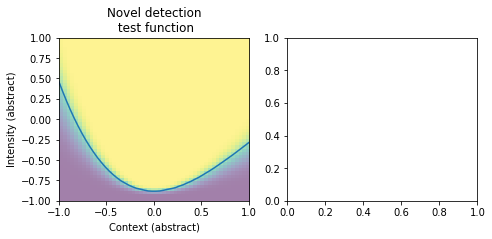

In [9]:

fig, ax = plt.subplots(1, 2, figsize=(7.5, 3))
novel_detection_p = norm.cdf(novel_detection_testfun(grid))
ax[0].imshow(novel_detection_p.reshape(gridsize, gridsize).T*100, aspect="auto", origin="lower", extent=[-1, 1, -1, 1], alpha=0.5, vmin=0, vmax=100)
level = 0.75
mono_grid = np.linspace(lb[1], ub[1], num=gridsize)
context_grid = np.linspace(lb[0], ub[0], num=gridsize)
threshold = get_lse_contour(novel_detection_p.reshape(gridsize, gridsize), mono_grid, level=level, lb=-1.0, ub=1.0).cpu().numpy()
ax[0].plot(context_grid, threshold)
ax[0].set_title("Novel detection\n test function")
ax[0].set_xlabel("Context (abstract)")
ax[0].set_ylabel("Intensity (abstract)")

In [10]:
novel_discrimination_p = norm.cdf(novel_discrimination_testfun(grid))
ax[1].imshow(novel_discrimination_p.reshape(gridsize, gridsize).T*100, aspect="auto", origin="lower", extent=[-1, 1, -1, 1], alpha=0.5, vmin=0, vmax=100)
threshold = get_lse_contour(novel_discrimination_p.reshape(gridsize, gridsize), mono_grid, level=level, lb=-1.0, ub=1.0).cpu().numpy()
ax[1].plot(context_grid, threshold)
ax[1].set_title("Novel discrimination\n test function")
ax[1].set_xlabel("Context (abstract)")
# ax[1].set_ylabel("Intensity (abstract)")
fig.tight_layout()
handles, labels = ax[1].get_legend_handles_labels()
cbr = fig.colorbar(ax[1].images[0], ax=ax)
cbr.set_label("Probability of Detection")


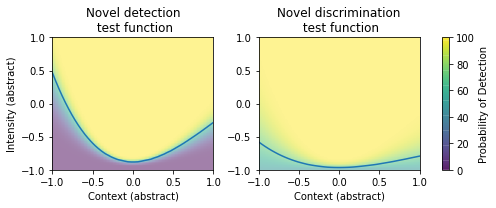

In [11]:
fig
# fig.savefig("novel_testfuns.pdf", dpi=200)

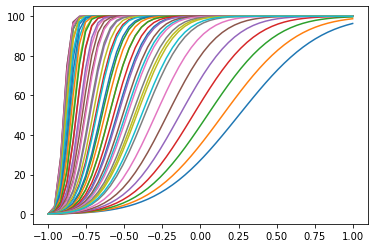

In [23]:
_ = plt.plot(np.linspace(lb[0], ub[0], gridsize), novel_detection_p.reshape(gridsize,gridsize).T*100)

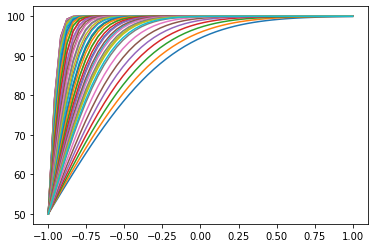

In [24]:
_ = plt.plot(np.linspace(lb[0], ub[0], gridsize), novel_discrimination_p.reshape(gridsize,gridsize).T*100)